# Demo notebook for parameter extraction and blob detection

### Pipeline

- Inputs:
    - sample FISH image
    - expert annotations of the image
- Operations: 
    - parameter extraction
    - blob detection
- Outputs:
    - coordinates of spots detected by blob detection

### Demo dataset

- smFISH sample image

In [1]:
from math import sqrt
from math import floor
from scipy import optimize
from skimage import data
from skimage.feature import blob_log
from skimage.color import rgb2gray
from skimage.io import imread
from sklearn.neighbors import KDTree
from numpy import pi, r_
import matplotlib.pyplot as plt
import numpy as np
import math, random, sys
sys.path.insert(0, '../../FISH-annotation/Annotation')
import util

### Metadata and parameters.

In [3]:
img_path = 'smfish.png'
img_height = 450
ref_coords_path = 'smfish_coords_with_header.csv'
margin = 4					# margin around each spot, in pixels
correctness_threshold = 4

### Read in the image and the expert annotations.

In [ ]:
im = imread(img_path)
im = rgb2gray(im)
ref_coords = np.genfromtxt(ref_coords_path, delimiter=',')[1:]
ref_kdt = util.csv_to_kdt(ref_coords_path, img_height)

# Find the sigma_max (the greatest spot size).

### Gaussian fit methods
Cell below from https://scipy-cookbook.readthedocs.io/items/FittingData.html.

In [ ]:
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

### Find the size of each spot identified by the expert and take the max.

In [5]:
sigma_max_list = []
for x, y in ref_coords:

    x_min = int(x)-margin if int(x)-margin >= 0 else 0
    x_max = int(x)+margin if int(x)+margin < im.shape[1] else im.shape[1]-1
    y_min = int(y)-margin if int(y)-margin >= 0 else 0
    y_max = int(y)+margin if int(y)+margin < im.shape[0] else im.shape[0]-1

    crop = im[y_min:y_max, x_min:x_max]
    params = fitgaussian(crop)
    fit = gaussian(*params)
    (height, x_param, y_param, width_x, width_y) = params
    sigma_max = math.sqrt(max(width_x, width_y)/2)
    sigma_max_list.append(sigma_max)
max_sigma = max(sigma_max_list)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)


In [6]:
print('greatest spot_sigma = ' + str(round(sigma_max, 2)))

greatest spot_sigma = 0.93


# Find the optimal intensity threshold. 

### Assign a range of intensity thresholds to test.

In [ ]:
thresholds = np.arange(0.02, 0.18, 0.005)

### Run blob detection with a range of thresholds and evaluate precision and recall overall.

In [7]:
best_precision_x_recall = 0
precision_list = []
recall_list = []
for threshold in thresholds:
    blobs_log = blob_log(im, max_sigma=10, num_sigma=10, threshold=threshold)
    blobs_list = []
    for r, c, sigma in blobs_log:
        blobs_list.append([c, r])
    blobs_kdt = KDTree(blobs_list, leaf_size=2, metric='euclidean')	# kdt is a kd tree with all the reference points

    num_blobs_total = len(blobs_log)
    num_ref_total = len(ref_coords)

    correct_blobs = []
    incorrect_blobs = []
    detected_ref = []
    undetected_ref = []

    # correct vs. incorrect

    for r, c, sigma in blobs_log:
        dist, ind = ref_kdt.query([[c, img_height-r]], k=1)
        if dist[0][0] < correctness_threshold:
            correct_blobs.append((r, c, sigma))
        else:
            incorrect_blobs.append((r, c, sigma))

    # detected vs. undetected

    for x, y in ref_coords:
        dist, ind = blobs_kdt.query([[x, y]], k=1)
        if dist[0][0] < correctness_threshold:
            detected_ref.append([x, y])
        else:
            undetected_ref.append([x, y])

    num_ref_detected = len(detected_ref)
    num_blobs_correct = len(correct_blobs)

    # calculate precision and recall and see if this is the best precision_x_recall we've found yet

    precision = len(correct_blobs)/(len(correct_blobs)+len(incorrect_blobs))
    recall = len(detected_ref)/(len(detected_ref)+len(undetected_ref))
    if (precision * recall) > best_precision_x_recall:
        best_precision_x_recall = precision * recall
        best_precision = precision
        best_recall = recall
        best_threshold = threshold
    precision_list.append(precision)
    recall_list.append(recall)

Text(0.5,1,'Precision-Recall, intensity threshold = np.arange(0.02, 0.18, 0.005)')

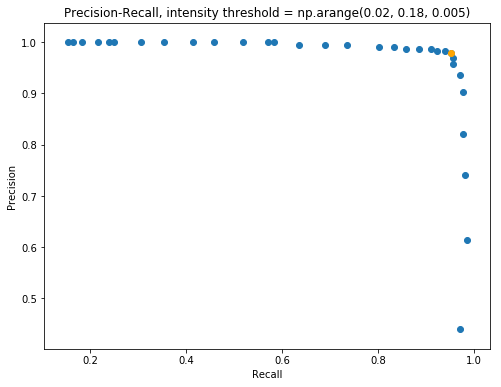

In [13]:
plt.figure(figsize = (8, 6))
plt.scatter(recall_list, precision_list)
plt.scatter([best_recall], [best_precision], c='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall, intensity threshold = np.arange(0.02, 0.18, 0.005)')

In [14]:
print('optimal intensity threshold = ' + str(round(best_threshold, 2)))

optimal intensity threshold = 0.06


### The max sigma and optimal intensity threshold found above with parameter extraction are now considered "tuned" parameters. 
If we are satisfied with them, we can use them with blob_log() on other smFISH chemistries.